In [1]:
import numpy as np
import random
import cv2
import chainer
import chainer.functions as F
from chainer.functions import caffe
from IPython.display import Image

In [2]:
file = open('./model/synset_words.txt')
categories = [x[10:-1] for x in file.readlines()]
%time caffeF = caffe.CaffeFunction('./model/bvlc_googlenet.caffemodel')

CPU times: user 24.9 s, sys: 577 ms, total: 25.5 s
Wall time: 25.8 s


In [3]:
def forward(x, t):
    y, = caffeF(inputs={'data': x},
              outputs=['loss3/classifier'],
              disable=['loss1/ave_pool', 'loss2/ave_pool'],
              train=False)
    return F.softmax_cross_entropy(y, t), F.accuracy(y, t)

def predict(x):
    y, = caffeF(inputs={'data': x},
              outputs=['loss3/classifier'],
              disable=['loss1/ave_pool', 'loss2/ave_pool'],
              train=False)
    return F.softmax(y)

In [4]:
# mean image
in_size = 224
mean_image = np.ndarray((3, 256, 256), dtype=np.float32)
mean_image[0] = 104
mean_image[1] = 117
mean_image[2] = 123

cropwidth = 256 - in_size
start = cropwidth // 2
stop = start + in_size
mean_image = mean_image[:, start:stop, start:stop].copy()
target_shape = (256, 256)
output_side_length=256

def prepare(image_path):
    image = cv2.imread(image_path)
    height, width, depth = image.shape
    new_height = output_side_length
    new_width = output_side_length
    if height > width:
        new_height = output_side_length * height / width
    else:
        new_width = output_side_length * width / height
    resized_img = cv2.resize(image, (new_width, new_height))
    height_offset = (new_height - output_side_length) / 2
    width_offset = (new_width - output_side_length) / 2
    image= resized_img[height_offset:height_offset + output_side_length,
    width_offset:width_offset + output_side_length]
    
    image = image.transpose(2, 0, 1)
    image = image[:, start:stop, start:stop].astype(np.float32)
    image -= mean_image
    
    x_batch = np.ndarray((1, 3, in_size,in_size), dtype=np.float32)
    x_batch[0]=image
    return x_batch

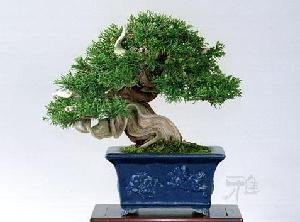

In [18]:
image_path = './data/bonsai/image_%04d.jpg' % random.randint(1,30)
Image(filename=image_path)

In [19]:
x = chainer.Variable(prepare(image_path), volatile=True)
scores = predict(x)

prediction = zip(scores.data[0].tolist(), categories)
prediction.sort(cmp=lambda x, y: cmp(x[0], y[0]), reverse=True)
for rank, (score, name) in enumerate(prediction[:10], start=1):
    print('#%02d | %s | %4.1f%%' % (rank, name, score * 100))

#01 | pot, flowerpot | 52.3%
#02 | pedestal, plinth, footstall | 43.9%
#03 | fountain |  0.7%
#04 | altar |  0.6%
#05 | caldron, cauldron |  0.5%
#06 | brass, memorial tablet, plaque |  0.3%
#07 | Egyptian cat |  0.2%
#08 | ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin |  0.2%
#09 | sundial |  0.2%
#10 | mortar |  0.1%
